In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_rows', 120)

In [3]:
def clean_and_drop(df):
    # 只篩選有包含 '住' 用途的交易案
    df = df.loc[df['Main_Usage_Living'] == 1]
    df = df.drop(columns=['Main_Usage_Living'])
    
    # 因為都是 0
    df = df.drop(columns=['Non_City_Land_Usage', 'Main_Usage_Walk', 
                          'Main_Usage_Selling',
                          'Main_Usage_SnE'])
    
    # 只有 344 筆是包含工廠用途，且都不具住宅用途，故剔除
    df = df.loc[df['Main_Usage_Manufacturing'] == 0]
    df = df.drop(columns=['Main_Usage_Manufacturing'])
    
    # 只有 76 筆是包含停車用途，且都不具住宅用途，故剔除
    df = df.loc[df['Main_Usage_Parking'] == 0]
    df = df.drop(columns=['Main_Usage_Parking'])
    
    # 只有 78 筆有農業用途，且都不具住宅用途，故剔除
    df = df.loc[df['Main_Usage_Farm'] == 0]
    df = df.drop(columns=['Main_Usage_Farm'])
    
    # NOTICE: 我沒有錢，所以我先只買 6 房以下的
    df = df.loc[df['room'] < 6]
    
    df = df.loc[df['trading_floors_count'] == 1]
    
    # 雖然有 95 個樣本包含地下室，但是樣本太少，可能不足以推廣
    # 所以先剔除，剔除完後，都是 0 所以直接 drop
    df = df.loc[df['including_basement'] == 0]
    df = df.drop(columns=['including_basement'])
    
    # 所有的樣本都不包含人行道，所以直接去除這個 feature
    df = df.drop(columns=['including_arcade'])

    # 剔除交易樓層高度是 -1 (原本有一個樣本)
    df = df.loc[df['min_floors_height'] != -1]

    # 剔除交易建物是 0 個樓層的情況
    df = df.loc[df['building_total_floors'] != 0]
    
    # 因為車位交易 50 坪以上的資料只有 22 筆，所以先去除
    # 因為浮點數在硬體儲存會有小數點，故不能直接用 == 50.0 去比較
    df = df.loc[df['Parking_Area'] < 49.5]
    
    # 把農舍，廠辦踢掉
    df = df.loc[df['Building_Types'] < 8]

    # 把超大轉移坪數刪掉
    df = df.loc[df['Transfer_Total_Ping'] < 150]
    
    # Transaction_Land == 0 只有 5 筆
    df = df.loc[df['Transaction_Land'] != 0]
    
    # 只取交易一個建物的案子
    df = df.loc[df['Transaction_Building'] == 1]
    
    # 交易車位數 > 3 只有 98 個案例，比較少，故去除
    df = df.loc[df['Transaction_Parking'] <= 3]
    
    # 目前不特別區分備註欄位是不是空的，因為用 one-hot encoding
    # 處理了，所以 Note_<tag> 不是全部都是 0 就代表有備註的項目
    df = df.drop(columns=['Note_Null'])
    
    # 去除政府承購, 去除後在 future data 中皆為 0
    df = df.loc[df['Note_Gov'] == 0]
    df = df.drop(columns=['Note_Gov'])
    
    # Only 85 cases in the dataset
    df = df.drop(columns=['Note_Layer'])

    # 毛胚屋，去除後皆為 0
    df = df.loc[df['Note_BlankHouse'] == 0]
    df = df.drop(columns=['Note_BlankHouse'])
    
    # 債權相關，只有 3 個，去除後皆為 0
    df = df.loc[df['Note_Debt'] == 0]
    df = df.drop(columns=['Note_Debt'])
    
    # 備註中有提到有電梯的只有 2 筆
    df = df.loc[df['Note_Elevator'] == 0]
    df = df.drop(columns=['Note_Elevator'])

    # Note_Shop, 只有 110 筆
    df = df.loc[df['Note_Shop'] == 0]
    df = df.drop(columns=['Note_Shop'])

    # All 0
    df = df.drop(columns=['Note_Additions', 'Note_Balcony', 
                          'Note_PublicUtilities', 'Note_PartRegister',
                          'Note_Negotiate', 'Note_OnlyParking',
                          'Note_Overbuild', 'Note_BuildWithLandholder',
                          'Note_Defect', 'Note_Renewal', 'Note_DistressSale ',
                          'Note_OverdueInherit', 'Note_DeformedLand'])
    
    # **Notice** 
    # 因為 future price data 應該是預設屋的資料，所以每一欄位的 presold 應該都要是 1
    # 但是有其他是 0, 所以直接刪掉這個欄位
    df = df.drop(columns=['Note_Presold'])
    
    # 只取跟親友無關的交易
    df = df.loc[df['Note_Relationships'] == 0]
    
    # 我先刪除 area_m2, 因為覺得跟 area_ping 的意義很類似，但是不確定會不會有些微差距。
    # 因為在 future data 中，manager 都是 0，所以也把這個欄位刪除
    # trading_floor_count 有 0 的情況，這樣應該不是房屋交易
    df = df.drop(columns=['address', 'area_m2', 'manager', 'Building_Material_stone', 
                     'TDATE', 'Total_price', '編號'])
    
    # Convert the categorical features' dtype to 'category'
    category_columns = ['Type', 'Month', 'Month_raw',
                       'room', 'City_Land_Usage', 'Main_Usage_Business',
                       'Building_Material_S', 'Building_Material_R', 'Building_Material_C',
                       'Building_Material_steel', 'Building_Material_B', 
                       'Building_Material_W', 'Building_Material_iron',
                       'Building_Material_tile', 'Building_Material_clay',
                       'Building_Material_RC_reinforce',
                       'Parking_Space_Types', 'Building_Types']
    df.loc[:, category_columns] = df.loc[:, category_columns].astype('category')
    return df

In [4]:
df = pd.read_csv('../merged_data/clean_data_future_train.csv')

In [5]:
df.columns

Index(['Place_id', 'Type', 'area_m2', 'area_ping', 'TDATE', 'Month', 'room',
       'hall', 'bathroom', 'compartment', 'manager', 'Total_price',
       'parking_price', '編號', 'address', 'trading_floors_count',
       'building_total_floors', 'min_floors_height', 'including_basement',
       'including_arcade', 'City_Land_Usage', 'Parking_Area',
       'Main_Usage_Walk', 'Main_Usage_Living', 'Main_Usage_Selling',
       'Main_Usage_Manufacturing', 'Main_Usage_Business', 'Main_Usage_Parking',
       'Main_Usage_SnE', 'Main_Usage_Farm', 'Building_Material_S',
       'Building_Material_R', 'Building_Material_C', 'Building_Material_steel',
       'Building_Material_stone', 'Building_Material_B', 'Building_Material_W',
       'Building_Material_iron', 'Building_Material_tile',
       'Building_Material_clay', 'Building_Material_RC_reinforce',
       'Non_City_Land_Usage', 'Parking_Space_Types', 'Building_Types',
       'Unit_Price_Ping', 'Transfer_Total_Ping', 'Non_City_Land_Code',
       'T

以 Place_id(市政區) 來看, 是 heavy-tailed distribution, 而且很多市政區的資料 \
剩下來的 data 有多少種不同的行政區，可以藉由下面的程式碼查看
```
df_future['Place_id'].unique().shape # original: (226,)
```

Number of distinct districts in the data: 226


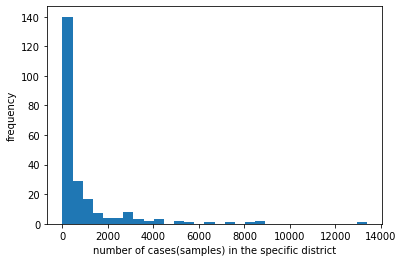

In [6]:
plt.hist(df['Place_id'].value_counts(), bins=30)
plt.xlabel('number of cases(samples) in the specific district')
plt.ylabel('frequency')
print('Number of distinct districts in the data:', df['Place_id'].unique().shape[0])

In [7]:
df['room'].value_counts()

3.0     89166
2.0     77696
4.0     15650
1.0      9863
0.0      9342
5.0      1889
6.0       127
7.0        10
10.0        7
9.0         1
Name: room, dtype: int64

In [8]:
# 查看賣出 0 樓層的交易類型是什麼? {'車位': 0, '房地(土地+建物)': 1, '房地(土地+建物)+車位': 2, '建物': 3}
print(df.loc[df['trading_floors_count'] == 0, 'Type'].value_counts())

1    8618
0     499
2       1
Name: Type, dtype: int64


In [9]:
df['min_floors_height'].value_counts()

 5     14972
 4     14955
 3     14085
 6     13905
 7     13324
 1     13281
 8     12367
 9     12248
 10    11572
 11    11159
 2     11158
 12    10487
 13     9845
 14     8726
 15     6985
 16     3097
 17     3040
 18     2828
 19     2639
 20     2238
 21     2031
 22     1781
 23     1511
 24     1295
 25      728
 26      684
 27      633
 28      593
 29      428
 30      235
 31      208
 32      174
 33      173
 34      112
 35       91
 36       52
 38       18
 37       17
 40        7
 43        6
 48        6
 54        5
 41        5
 44        5
 55        5
 52        5
 42        4
 51        4
 49        4
 46        4
 39        4
 53        3
 47        3
 56        2
 77        2
 45        1
-1         1
Name: min_floors_height, dtype: int64

In [10]:
df['including_arcade'].unique()

array([0])

In [11]:
df['including_arcade'].value_counts()

0    203751
Name: including_arcade, dtype: int64

Parking Area > 50: 22
0.0      34428
9.0      31147
8.0      27541
10.0     25689
7.0      19023
11.0     17825
12.0      7774
6.0       6960
5.0       5817
4.0       4415
13.0      3269
3.0       2856
14.0      2377
2.0       1727
18.0      1622
17.0      1605
15.0      1600
19.0      1484
16.0      1427
20.0      1178
22.0       883
21.0       808
23.0       738
24.0       354
25.0       244
26.0       167
27.0       147
1.0        109
28.0        82
29.0        75
31.0        66
30.0        60
32.0        41
36.0        39
34.0        27
35.0        20
41.0        19
38.0        18
37.0        14
40.0        13
33.0        12
39.0         8
45.0         5
47.0         5
53.0         4
43.0         3
46.0         3
48.0         3
51.0         2
72.0         2
89.0         1
155.0        1
153.0        1
143.0        1
138.0        1
122.0        1
96.0         1
60.0         1
88.0         1
86.0         1
76.0         1
42.0         1
52.0         1
50.0         1
49.0         1
191

Text(0, 0.5, 'frequency')

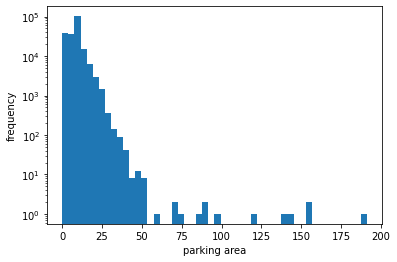

In [12]:
print('Parking Area > 50:', df.loc[df['Parking_Area'] > 49.5].shape[0])
print(df['Parking_Area'].sort_values().value_counts())
plt.hist(df['Parking_Area'], bins=50, log=True)
plt.xlabel('parking area')
plt.ylabel('frequency')

In [13]:
df['City_Land_Usage'].value_counts()

1    130024
4     54333
0     10977
7      7320
2       699
3       398
Name: City_Land_Usage, dtype: int64

In [14]:
df['Non_City_Land_Usage'].unique()

array([0])

In [15]:
df['Main_Usage_Manufacturing'].value_counts()

0    203407
1       344
Name: Main_Usage_Manufacturing, dtype: int64

In [16]:
df.loc[df['Main_Usage_Manufacturing'] == 1, 'Main_Usage_Living'].value_counts()

0    344
Name: Main_Usage_Living, dtype: int64

In [17]:
df['Main_Usage_Parking'].value_counts()

0    203675
1        76
Name: Main_Usage_Parking, dtype: int64

In [18]:
df.loc[df['Main_Usage_Parking'] == 1, 'Main_Usage_Living'].value_counts()

0    76
Name: Main_Usage_Living, dtype: int64

In [19]:
df['Main_Usage_Business'].value_counts()

0    193293
1     10458
Name: Main_Usage_Business, dtype: int64

In [20]:
df['Main_Usage_SnE'].unique()

array([0])

In [21]:
df['Main_Usage_Farm'].value_counts()

0    203673
1        78
Name: Main_Usage_Farm, dtype: int64

In [22]:
df.loc[df['Main_Usage_Farm'] == 1, 'Main_Usage_Living'].value_counts()

0    78
Name: Main_Usage_Living, dtype: int64

In [23]:
df['Parking_Space_Types'].value_counts()

0    153632
1     31285
2     10873
3      3493
4      1932
5      1248
6       703
7       585
Name: Parking_Space_Types, dtype: int64

In [24]:
# 住宅大樓(11層含以上有電梯): 0
# 其他: 1
# 透天厝: 2
# 華廈(10層含以下有電梯): 3
# 公寓(5樓含以下無電梯): 4
# 套房(1房1廳1衛): 5
# 店面(店鋪): 6
# 辦公商業大樓: 7
# 廠辦: 8
# 農舍: 9
# 工廠: 10
# 倉庫: 11
df['Building_Types'].value_counts()

0    169537
1     19747
2      8947
3      2134
4      1619
5       904
6       342
7       311
8       168
9        42
Name: Building_Types, dtype: int64

In [25]:
# Redudant (compared to 'Month')
df['TDATE'].value_counts()

2021-09-18    636
2021-09-11    609
2021-11-05    585
2021-09-26    575
2021-11-06    563
             ... 
2017-01-30      2
2018-02-15      2
2017-01-27      2
2017-02-01      1
2017-01-29      1
Name: TDATE, Length: 1825, dtype: int64

Text(0, 0.5, 'frequency')

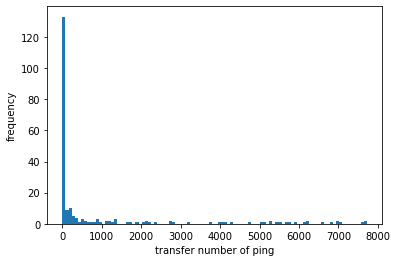

In [26]:
plt.hist(df['Transfer_Total_Ping'].value_counts(), bins=100)
plt.xlabel('transfer number of ping')
plt.ylabel('frequency')

In [27]:
df.loc[df['Transfer_Total_Ping'] > 150, 'Transfer_Total_Ping'].value_counts()

2126.0      178
177.0        38
207.0        19
151.0        13
159.0         7
174.0         7
171.0         7
173.0         7
175.0         6
189.0         6
161.0         6
183.0         5
163.0         5
219.0         5
204.0         5
176.0         5
162.0         5
193.0         4
155.0         4
165.0         4
153.0         4
202.0         3
190.0         3
160.0         3
359.0         3
209.0         3
156.0         3
197.0         2
186.0         2
168.0         2
187.0         2
181.0         2
182.0         2
213.0         2
201.0         2
172.0         2
169.0         2
299.0         2
194.0         1
214.0         1
195.0         1
627.0         1
301.0         1
457.0         1
342.0         1
272.0         1
211.0         1
293.0         1
320895.0      1
198.0         1
320.0         1
205.0         1
291.0         1
529.0         1
273.0         1
289.0         1
221.0         1
154.0         1
252.0         1
167.0         1
223.0         1
170.0         1
152.0   

In [28]:
df[['Month_raw', 'Month', 'TDATE']]

,Month_raw,Month,TDATE
0,201612,201701,2017-01-02
1,201612,201701,2017-01-21
2,201701,201702,2017-02-09
3,201701,201702,2017-02-19
4,201701,201702,2017-02-12
...,...,...,...
203746,202111,202112,2021-12-29
203747,202111,202112,2021-12-16
203748,202111,202112,2021-12-17
203749,202111,202112,2021-12-20


(array([ 1254.,  1540.,   808.,  1693.,  2096.,  3089., 14927.,  8536.,
        14494., 33541., 30269., 19907.,  2941.,  9297.,  8534.,  6483.,
            0., 11833., 11117., 21392.]),
 array([ 99.59  ,  99.8915, 100.193 , 100.4945, 100.796 , 101.0975,
        101.399 , 101.7005, 102.002 , 102.3035, 102.605 , 102.9065,
        103.208 , 103.5095, 103.811 , 104.1125, 104.414 , 104.7155,
        105.017 , 105.3185, 105.62  ]),
 <BarContainer object of 20 artists>)

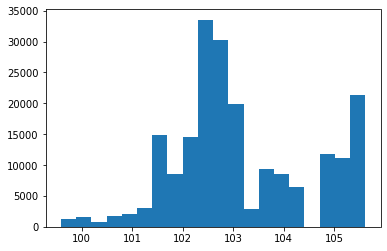

In [29]:
plt.hist(df['CPI'], bins=20)

(array([ 5024.,  4081.,  6565., 13207., 20084.,  5367., 12179., 12416.,
        16556.,  3569.,  9111.,  5237., 12027.,  3142., 11350., 11024.,
         5573., 14730., 21511., 10998.]),
 array([-1.2081  , -1.005035, -0.80197 , -0.598905, -0.39584 , -0.192775,
         0.01029 ,  0.213355,  0.41642 ,  0.619485,  0.82255 ,  1.025615,
         1.22868 ,  1.431745,  1.63481 ,  1.837875,  2.04094 ,  2.244005,
         2.44707 ,  2.650135,  2.8532  ]),
 <BarContainer object of 20 artists>)

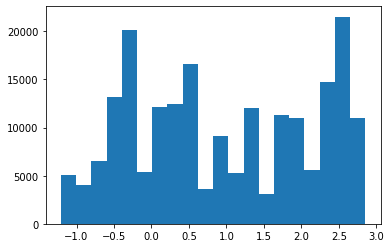

In [30]:
plt.hist(df['CPI_rate'], bins=20)

(array([49965., 44335., 37027.,  6652., 29817.,  9105.,  2897.,     0.,
        11833.,     0.,     0.,  6483.,     0.,     0.,  5637.]),
 array([4.82      , 4.90933333, 4.99866667, 5.088     , 5.17733333,
        5.26666667, 5.356     , 5.44533333, 5.53466667, 5.624     ,
        5.71333333, 5.80266667, 5.892     , 5.98133333, 6.07066667,
        6.16      ]),
 <BarContainer object of 15 artists>)

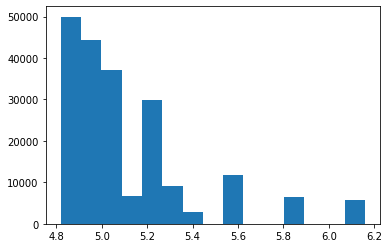

In [31]:
plt.hist(df['unemployment rate'], bins=15)

In [32]:
df['D_Year_Month_Day']

KeyError: 'D_Year_Month_Day'

In [33]:
print(df['Transaction_Land'].value_counts())

1    145147
2     29130
3     12124
4      7310
6      2893
5      2553
9      1950
8      1459
7      1180
0         5
Name: Transaction_Land, dtype: int64


In [34]:
# 交易建物的數量
df['Transaction_Building'].value_counts()

1    203419
2       217
0       115
Name: Transaction_Building, dtype: int64

In [35]:
print(df['Transaction_Parking'].value_counts())
print(df.loc[df['Transaction_Parking'] > 3]['Main_Usage_Living'].value_counts())

# Noisy!!
print(df.loc[df['Transaction_Parking'] > 3]['Note_Parking'].value_counts())

print(df.query('0 < Transaction_Parking and Transaction_Parking < 4')['Note_Parking'].value_counts())

df['Transaction_Parking'].value_counts()

1    158568
0     31213
2     13170
3       685
4        98
6         6
5         4
7         3
9         3
8         1
Name: Transaction_Parking, dtype: int64
1    70
0    45
Name: Main_Usage_Living, dtype: int64
0    106
1      9
Name: Note_Parking, dtype: int64
0    171210
1      1213
Name: Note_Parking, dtype: int64


1    158568
0     31213
2     13170
3       685
4        98
6         6
5         4
7         3
9         3
8         1
Name: Transaction_Parking, dtype: int64

In [36]:
df['Note_Null'].value_counts()

1    187049
0     16702
Name: Note_Null, dtype: int64

In [37]:
df['Note_Additions'].value_counts()

0    203751
Name: Note_Additions, dtype: int64

In [38]:
df['Note_Presold'].value_counts()

0    197405
1      6346
Name: Note_Presold, dtype: int64

In [39]:
df['Note_Relationships'].value_counts()

0    202250
1      1501
Name: Note_Relationships, dtype: int64

In [40]:
df['Note_Balcony'].value_counts()

0    203751
Name: Note_Balcony, dtype: int64

In [41]:
df['Note_PublicUtilities'].value_counts()

0    203751
Name: Note_PublicUtilities, dtype: int64

In [42]:
df['Note_PartRegister'].value_counts()

0    203751
Name: Note_PartRegister, dtype: int64

In [43]:
df['Note_Negotiate'].value_counts()

0    203751
Name: Note_Negotiate, dtype: int64

In [44]:
# 是不是包含車位
df['Note_Parking'].value_counts()

0    202412
1      1339
Name: Note_Parking, dtype: int64

In [47]:
df['Note_OnlyParking'].value_counts()

0    203751
Name: Note_OnlyParking, dtype: int64

In [48]:
# 政府機關承購
df['Note_Gov'].value_counts()

0    203751
Name: Note_Gov, dtype: int64

In [49]:
# 頂樓加蓋
df['Note_Overbuild'].value_counts()

0    203751
Name: Note_Overbuild, dtype: int64

In [50]:
# TODO: Discussion
df['Note_Decoration'].value_counts()

0    200460
1      3291
Name: Note_Decoration, dtype: int64

In [51]:
# TODO: Discussion
df['Note_Furniture'].value_counts()

0    199152
1      4599
Name: Note_Furniture, dtype: int64

In [52]:
# 夾層
df['Note_Layer'].value_counts()

0    203666
1        85
Name: Note_Layer, dtype: int64

In [53]:
# 建商與地主合建案
df['Note_BuildWithLandholder'].value_counts()

0    203751
Name: Note_BuildWithLandholder, dtype: int64

In [54]:
# 毛胚屋
df['Note_BlankHouse'].value_counts()

0    203173
1       578
Name: Note_BlankHouse, dtype: int64

In [55]:
# 瑕疵 or 凶宅
df['Note_Defect'].value_counts()

0    203751
Name: Note_Defect, dtype: int64

In [56]:
# 債權債務
df['Note_Debt'].value_counts()

0    203748
1         3
Name: Note_Debt, dtype: int64

In [57]:
df['Note_Elevator'].value_counts()

0    203749
1         2
Name: Note_Elevator, dtype: int64

In [58]:
# 都更效益
df['Note_Renewal'].value_counts()

0    203751
Name: Note_Renewal, dtype: int64

In [59]:
# NOTICE:
# Trailing blank in the column name
# 急賣
df['Note_DistressSale '].value_counts()

0    203751
Name: Note_DistressSale , dtype: int64

In [60]:
# 逾期未辦繼承
df['Note_OverdueInherit'].value_counts()

0    203751
Name: Note_OverdueInherit, dtype: int64

In [61]:
# 畸零地
df['Note_DeformedLand'].value_counts()

0    203751
Name: Note_DeformedLand, dtype: int64

In [62]:
df['Note_Shop'].value_counts()

0    203641
1       110
Name: Note_Shop, dtype: int64

In [63]:
df = clean_and_drop(df)

In [64]:
df

,Place_id,Type,area_ping,Month,room,hall,bathroom,compartment,parking_price,trading_floors_count,building_total_floors,min_floors_height,City_Land_Usage,Parking_Area,Main_Usage_Business,Building_Material_S,Building_Material_R,Building_Material_C,Building_Material_steel,Building_Material_B,Building_Material_W,Building_Material_iron,Building_Material_tile,Building_Material_clay,Building_Material_RC_reinforce,Parking_Space_Types,Building_Types,Unit_Price_Ping,Transfer_Total_Ping,Non_City_Land_Code,Transaction_Land,Transaction_Building,Transaction_Parking,Note_Relationships,Note_Parking,Note_Decoration,Note_Furniture,Month_raw,CPI,CPI_rate,unemployment rate,Pain_index_3month,ppen_price,high_price,low_price,close_price,qmatch,amt_millon,return_rate_month,Turnover_rate_month,outstanding_share_thousand,Capitalization_million,excess total _ million_usdollars,import_price_index_usdollars,export_price_index_usdollars,export_million_usdollars,import_million_usdollars,survival_mobility_rate,live_deposit_mobility_interest_rate,CCI_3month,construction_engineering_index
1,242,0,3.0,201701,2.0,2.0,1.0,1,0.0,1,18,11,4,8.0,1,0,1,1,0,0,0,0,0,0,0,0,0,309908.8326,33.0,0,1,1,1,0,0,0,0,201612,100.34,1.6925,4.99,5.4825,9245.55,9430.34,9078.64,9253.50,35298,1235892,0.1384,5.1209,689283423,27201163,82482,103.70,102.09,23247.9,20664.4,0.08,0.2,77.22,101.05
2,242,0,2.0,201702,1.0,1.0,1.0,1,0.0,1,18,10,4,8.0,1,0,1,1,0,0,0,0,0,0,0,0,0,322579.9640,27.0,0,1,1,1,0,0,0,0,201701,100.32,2.2422,4.98,6.0222,9252.56,9468.34,9235.95,9447.95,28103,1024124,2.1014,4.0707,690360680,27807016,58813,105.56,103.26,21816.5,19971.2,0.08,0.2,74.35,101.67
3,242,0,2.0,201702,1.0,1.0,1.0,1,0.0,1,18,11,4,8.0,1,0,1,1,0,0,0,0,0,0,0,0,0,316923.7402,27.0,0,1,1,1,0,0,0,0,201701,100.32,2.2422,4.98,6.0222,9252.56,9468.34,9235.95,9447.95,28103,1024124,2.1014,4.0707,690360680,27807016,58813,105.56,103.26,21816.5,19971.2,0.08,0.2,74.35,101.67
4,242,0,4.0,201702,3.0,2.0,1.0,1,0.0,1,18,14,4,8.0,1,0,1,1,0,0,0,0,0,0,0,0,0,304698.8918,39.0,0,1,1,1,0,0,0,0,201701,100.32,2.2422,4.98,6.0222,9252.56,9468.34,9235.95,9447.95,28103,1024124,2.1014,4.0707,690360680,27807016,58813,105.56,103.26,21816.5,19971.2,0.08,0.2,74.35,101.67
5,242,0,4.0,201702,3.0,2.0,1.0,1,0.0,1,18,15,4,8.0,1,0,1,1,0,0,0,0,0,0,0,0,0,299601.3482,39.0,0,1,1,1,0,0,0,0,201701,100.32,2.2422,4.98,6.0222,9252.56,9468.34,9235.95,9447.95,28103,1024124,2.1014,4.0707,690360680,27807016,58813,105.56,103.26,21816.5,19971.2,0.08,0.2,74.35,101.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203745,892,1,11.0,202112,3.0,2.0,2.0,1,0.0,1,5,3,1,0.0,1,0,1,1,0,0,0,0,0,0,0,1,1,194040.5426,27.0,0,1,1,0,0,0,0,0,202111,105.62,2.8532,4.87,6.5132,17021.80,17986.20,17021.80,17427.80,120589,7668790,2.5920,16.3983,735375176,53502315,74619,127.23,115.75,38330.6,35648.9,0.04,0.1,73.33,125.81
203746,892,1,12.0,202112,3.0,2.0,2.0,1,0.0,1,5,1,1,0.0,1,0,1,1,0,0,0,0,0,0,0,1,1,224754.7304,29.0,0,1,1,0,0,0,0,0,202111,105.62,2.8532,4.87,6.5132,17021.80,17986.20,17021.80,17427.80,120589,7668790,2.5920,16.3983,735375176,53502315,74619,127.23,115.75,38330.6,35648.9,0.04,0.1,73.33,125.81
203748,880,1,5.0,202112,2.0,1.0,2.0,1,0.0,1,9,5,0,0.0,1,0,1,1,0,0,0,0,0,0,0,1,1,192430.6180,20.0,3,1,1,0,0,0,0,0,202111,105.62,2.8532,4.87,6.5132,17021.80,17986.20,17021.80,17427.80,120589,7668790,2.5920,16.3983,735375176,53502315,74619,127.23,115.75,38330.6,35648.9,0.04,0.1,73.33,125.81
203749,880,1,5.0,202112,2.0,1.0,2.0,1,0.0,1,9,8,0,0.0,1,0,1,1,0,0,0,0,0,0,0,1,1,119818.7210,35.0,3,1,1,0,0,0,0,0,202111,105.62,2.8532,4.87,6.5132,17021.80,17986.20,17021.80,17427.80,120589,7668790,2.5920,16.3983,735375176,53502315,74619,127.23,115.75,38330.6,35648.9,0.04,0.1,73.33,125.81
